In [8]:
!pip install natasha

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Извлечение сущностей

In [9]:
import numpy as np
import pandas as pd
import os
from glob import glob

In [10]:
data_path = r"path_to_data"
archives = glob(data_path + "/*.zip")

In [11]:
!mkdir data
import zipfile
for archive_path in archives:
  with zipfile.ZipFile(archive_path, 'r') as zip_ref:
    zip_ref.extractall("data")

mkdir: cannot create directory ‘data’: File exists


In [12]:
text = []
for path in glob("data/*.csv"): 
  text += list(pd.read_csv(path)["text"])

In [13]:
from natasha import Doc, MorphVocab, NewsEmbedding, Segmenter, NewsNERTagger

- Segmenter на токены делит текст
- NewsNERTagger - выделяет сущности
- MorphVocab - морфологический словарь вроде как

In [14]:
emb = NewsEmbedding()
segmenter = Segmenter()
ner_tagger = NewsNERTagger(emb)
morph_vocab = MorphVocab()

In [15]:
from natasha import (LOC, PER, NamesExtractor,
    DatesExtractor,
    MoneyExtractor,
    AddrExtractor)

names_extractor = NamesExtractor(morph_vocab)
dates_extractor = DatesExtractor(morph_vocab)
money_extractor = MoneyExtractor(morph_vocab)
addr_extractor = AddrExtractor(morph_vocab)

In [16]:
from natasha import NewsMorphTagger, NewsSyntaxParser
syntax_parser = NewsSyntaxParser(emb)
morph_tagger = NewsMorphTagger(emb)

Просто ⚡️ убирает

In [17]:
for idx, _ in enumerate(text):
  if text[idx] == "none" or text[idx] is np.nan:
    text.pop(idx)
  text[idx] = text[idx].replace("⚡️", "")

Собирает все лоакции упомянутые в посте и сохраняет их. Можно добавить `_.type == PER` если нужны люди и `_.type == ORG` для организаций.

In [18]:
from tqdm.notebook import tqdm

In [19]:
from natasha import (
    Doc,
    LOC, 
    PER,
    MorphVocab,
    NewsEmbedding,
    Segmenter,
    NewsNERTagger,
    NewsSyntaxParser,
    NewsMorphTagger
    )
from pprint import pprint

class NERParser:
  def __init__(self, types=[LOC]):
      self.types = types
      emb = NewsEmbedding()
      self.segmenter = Segmenter()
      self.morph_vocab = MorphVocab()
      self.ner_tagger = NewsNERTagger(emb)
      self.syntax_parser = NewsSyntaxParser(emb)
      self.morph_tagger = NewsMorphTagger(emb)

  def __call__(self, text):
      doc = Doc(text)
      doc.segment(self.segmenter)
      doc.tag_morph(self.morph_tagger)
      doc.parse_syntax(self.syntax_parser)
      doc.tag_ner(self.ner_tagger)
      for span in doc.spans:
          span.normalize(self.morph_vocab)
      entities = {}
      for t in self.types:
          entities[str(t)] = [_.normal for _ in doc.spans if _.type == t]
      return entities

if __name__ == "__main__":
    ner = NERParser(types=[LOC, PER])
    pprint(ner('Посол Израиля на Украине Йоэль Лион признался, что пришел в шок, узнав о решении властей Львовской области объявить 2019 год годом лидера запрещенной в России Организации украинских националистов (ОУН) Степана Бандеры. Свое заявление он разместил в Twitter. «Я не могу понять, как прославление тех, кто непосредственно принимал участие в ужасных антисемитских преступлениях, помогает бороться с антисемитизмом и ксенофобией. Украина не должна забывать о преступлениях, совершенных против украинских евреев, и никоим образом не отмечать их через почитание их исполнителей», — написал дипломат. 11 декабря Львовский областной совет принял решение провозгласить 2019 год в регионе годом Степана Бандеры в связи с празднованием 110-летия со дня рождения лидера ОУН (Бандера родился 1 января 1909 года). В июле аналогичное решение принял Житомирский областной совет. В начале месяца с предложением к президенту страны Петру Порошенко вернуть Бандере звание Героя Украины обратились депутаты Верховной Рады. Парламентарии уверены, что признание Бандеры национальным героем поможет в борьбе с подрывной деятельностью против Украины в информационном поле, а также остановит «распространение мифов, созданных российской пропагандой». Степан Бандера (1909-1959) был одним из лидеров Организации украинских националистов, выступающей за создание независимого государства на территориях с украиноязычным населением. В 2010 году в период президентства Виктора Ющенко Бандера был посмертно признан Героем Украины, однако впоследствии это решение было отменено судом. '))


{'LOC': ['Израиль',
         'Украина',
         'Львовская область',
         'Россия',
         'Украина',
         'Украина',
         'Украина',
         'Украина'],
 'PER': ['Йоэль Лион',
         'Степан Бандера',
         'Степан Бандера',
         'Петр Порошенко',
         'Бандера',
         'Бандера',
         'Степан Бандера',
         'Виктор Ющенко',
         'Бандера']}


In [20]:
entities = {}
n_samples = 1000
for idx, t in enumerate(tqdm(text[:n_samples])):
  if t == "none" or t is np.nan:
    continue
  doc = Doc(t)
  doc.segment(segmenter)
  doc.tag_morph(morph_tagger)
  doc.parse_syntax(syntax_parser)
  doc.tag_ner(ner_tagger)
  for span in doc.spans:
    span.normalize(morph_vocab)
  entities[idx] = [_.normal for _ in doc.spans if _.type == LOC]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [21]:
entities

{0: ['США', 'США', 'США'],
 1: ['Россия', 'Россия', 'РФ', 'РФ'],
 2: ['Китай', 'Гонконг'],
 3: ['Китай', 'США', 'Вашингтон', 'Пекин', 'США'],
 4: [],
 5: ['Россия',
  'РФ',
  'Центральная Европа',
  'Балтия',
  'Москва',
  'Санкт-Петербург'],
 6: ['США', 'США', 'США', 'США'],
 7: [],
 8: ['КИЕВ', 'Рейтер', 'Украина', 'Киев', 'Киев', 'Украина'],
 9: ['Китай', 'Китай'],
 10: ['РФ',
  'США',
  'Китай',
  'Азия',
  'Европа',
  'США',
  'Китай',
  'США',
  'Вашингтон',
  'КНР',
  'Китай',
  'США',
  'Штаты'],
 11: [],
 12: ['Дальний Восток', 'Россия'],
 13: ['МОСКВА', 'Рейтер'],
 14: ['КИЕВ', 'Рейтер', 'Украина', 'Украина'],
 15: ['МОСКВА', 'Рейтер', 'РФ', 'Усть-Луге', 'РФ'],
 16: ['КИЕВ', 'Рейтер', 'Украина'],
 17: ['ЕС',
  'Испания',
  'Брюссель',
  'Германия',
  'США',
  'Китай',
  'Великобритания',
  'ЕС',
  'Королевство'],
 18: ['Россия', 'Россия'],
 19: ['США'],
 20: [],
 21: ['РФ', 'США', 'США'],
 22: ['Пакистан', 'Таиланд', 'Вьетнам', 'Индия', 'РФ', 'Дальний Восток'],
 23: [],
 24: 

# Эмбеденги из предложенний с помощью RuSBERT
- [hugginge_face](https://huggingface.co/sberbank-ai/sbert_large_nlu_ru)
- [habr](https://habr.com/ru/company/sberdevices/blog/527576/)

In [22]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Просто тестим. Переводит предложения к вектору размера 1024 - это и есть эмбединг предложенния.

In [23]:
from transformers import AutoTokenizer, AutoModel
import torch

#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

#Sentences we want sentence embeddings for
sentences = ['Привет! Как твои дела?',
             'А правда, что 42 твое любимое число?']

#Load AutoModel from huggingface model repository
tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/sbert_large_nlu_ru")
model = AutoModel.from_pretrained("sberbank-ai/sbert_large_nlu_ru")
model.to("cuda")

#Tokenize sentences
encoded_input = tokenizer(sentences, padding=True, truncation=True, max_length=24, return_tensors='pt')
encoded_input = {k:v.to("cuda") for k, v in encoded_input.items()}

#Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

#Perform pooling. In this case, mean pooling
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

In [24]:
sentence_embeddings.cpu().numpy()

array([[ 0.45867693, -0.2511488 , -0.4554171 , ...,  0.32620466,
        -0.9852325 ,  0.2071278 ],
       [ 0.65622866, -0.71123177,  0.4682496 , ..., -0.15917538,
        -0.5915386 ,  0.8491468 ]], dtype=float32)

Собираю эмбеденги предложений из постов. То есть добавляю матрицу для каждого поста `(n_sentences, 1024)`

In [25]:
embeddings = []
n_samples = 3000
for idx, t in enumerate(tqdm(text[:n_samples])):
  if t == "none" or t is np.nan:
    continue
  doc = Doc(t)
  doc.segment(segmenter)
  sentences = [s.text for s in doc.sents]
  encoded_input = tokenizer(sentences, padding=True, truncation=True, max_length=24, return_tensors='pt')
  encoded_input = {k:v.to("cuda") for k, v in encoded_input.items()}

  #Compute token embeddings
  with torch.no_grad():
      model_output = model(**encoded_input)

  #Perform pooling. In this case, mean pooling
  sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
  embeddings.append(sentence_embeddings.cpu().numpy())

  0%|          | 0/3000 [00:00<?, ?it/s]

Просто усредняю, что плохо, но идей других нет )

In [26]:
# docs_embeddings = []
# for emb in embeddings:
#     doc_emb = emb.mean(axis=0)[np.newaxis, ...]
#     docs_embeddings.append(doc_emb)
docs_embeddings = np.concatenate(embeddings, axis=0)

In [27]:
docs_embeddings.shape

(34968, 1024)

Пробую теперь это всё кластеризовать. DBSCAN работает без изначального задания кластеров и получается у него плохо, возможно это из-за высокой размерности эмбеденга (при увелечение размерности растут и расстояния). Как видно получается плохо.

In [28]:
from sklearn.cluster import DBSCAN, KMeans
from collections import Counter
dbscan = DBSCAN(eps=0.3, metric="cosine", leaf_size=30)
dbscan.fit(docs_embeddings)
Counter(dbscan.labels_)

Counter({0: 1536, 1: 32885, 2: 85, -1: 456, 3: 6})

Kmeans

In [29]:
inertia_list = []
for k in range(2, 20):
    kmeans = KMeans(k)
    kmeans.fit(docs_embeddings)
    inertia_list.append(kmeans.inertia_)

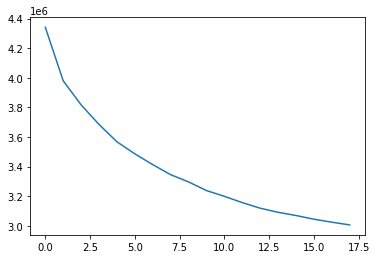

In [30]:
import matplotlib.pyplot as plt
plt.plot(inertia_list) 

In [31]:
kmeans = KMeans(6)
kmeans.fit(docs_embeddings)
Counter(kmeans.labels_)

Counter({3: 1537, 5: 9737, 2: 8579, 4: 9170, 0: 2226, 1: 3719})

In [35]:
for label in np.unique(kmeans.labels_):
  indecies = np.arange(len(kmeans.labels_))[kmeans.labels_ == label]
  print("-"*50)
  print("Labels is ", label)
  for idx in indecies[:3]:
    print(text[idx])

--------------------------------------------------
Labels is  0






КИЕВ (Рейтер) - Украинский парламент поддержал предложение президента Владимира Зеленского и назначил новым премьер-министром 35-летнего юриста Алексея Гончарука, занимавшего с мая пост заместителя главы офиса президента.
За предложенного Зеленским кандидата на первом заседании парламента проголосовали 290 депутатов при необходимом минимуме в 226 голосов.
Президентская партия "Слуга народа" выиграла 254 мандата в 450-местной Раде и впервые в истории независимой Украины имеет достаточно голосов для назначения премьера, министров и принятия законов без формирования коалиции с другими политическими силами.
(Наталия Зинец. Редактор Мария Грабарь) 




За полугодие банк "Русский стандарт" увеличил чистую прибыль по МСФО в 1,5 раза


Банк "Русский стандарт" в первом полугодии 2019 года увеличил чистую прибыль по МСФО в 1,5 раза в годовом сравнении - до 3,56 млрд рублей, говорится в пресс-релизе банка.
"Расходы на резервы с